In [ ]:
# must occur first:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/CSC442 Team Project/Output/world_combined/final_data_cleaned.csv')
df.head()

,Unnamed: 0,Date,Crypto Volatility,Crypto Growth,Bonds Volatility,Bonds Growth,Major Currencies Volatility,Major Currencies Growth,Other Currencies Volatility,Other Currencies Growth,...,Indices Growth,Money Market Growth,Stooqs Stocks Volatility,Stooqs Stocks Growth,Crypto Volatile,Bonds Volatile,Major Currencies Volatile,Other Currencies Volatile,Indices Volatile,Stooqs Stocks Volatile
0,0,2010-07-19,0.01584,-0.00504,0.043850,-0.001233,2.232157,-1.335385,0.168446,-0.043343,...,23.229492,-0.1648,1.04,1.04,False,False,False,False,False,False
1,1,2010-07-20,0.00755,-0.00606,0.036574,-0.016573,2.213713,1.139422,0.166088,0.033777,...,20.939833,-0.0288,1.92,-1.92,False,False,False,False,False,False
2,2,2010-07-21,0.01287,0.00447,0.037135,-0.025235,1.920781,0.361047,0.168475,0.063285,...,11.914667,-0.0200,8.19,8.19,False,False,False,False,False,True
3,3,2010-07-22,0.03131,-0.02871,0.042159,-0.018359,1.666740,0.054496,0.130519,0.009895,...,97.244746,0.0408,7.23,7.23,False,False,False,False,False,False
4,4,2010-07-23,0.01717,0.01212,0.041130,-0.013021,2.040011,-0.325834,0.163199,0.074019,...,24.910169,0.0508,6.32,6.32,False,False,False,False,False,False


In [ ]:
# step one: isolate key columns

growth_columns = ["Crypto Growth", "Bonds Growth", "Major Currencies Growth", "Other Currencies Growth", "Indices Growth", "Money Market Growth", "Stooqs Stocks Growth"]
growth_df = df[growth_columns].copy()

growth_df.head()

,Crypto Growth,Bonds Growth,Major Currencies Growth,Other Currencies Growth,Indices Growth,Money Market Growth,Stooqs Stocks Growth
0,-0.00504,-0.001233,-1.335385,-0.043343,23.229492,-0.1648,1.04
1,-0.00606,-0.016573,1.139422,0.033777,20.939833,-0.0288,-1.92
2,0.00447,-0.025235,0.361047,0.063285,11.914667,-0.0200,8.19
3,-0.02871,-0.018359,0.054496,0.009895,97.244746,0.0408,7.23
4,0.01212,-0.013021,-0.325834,0.074019,24.910169,0.0508,6.32


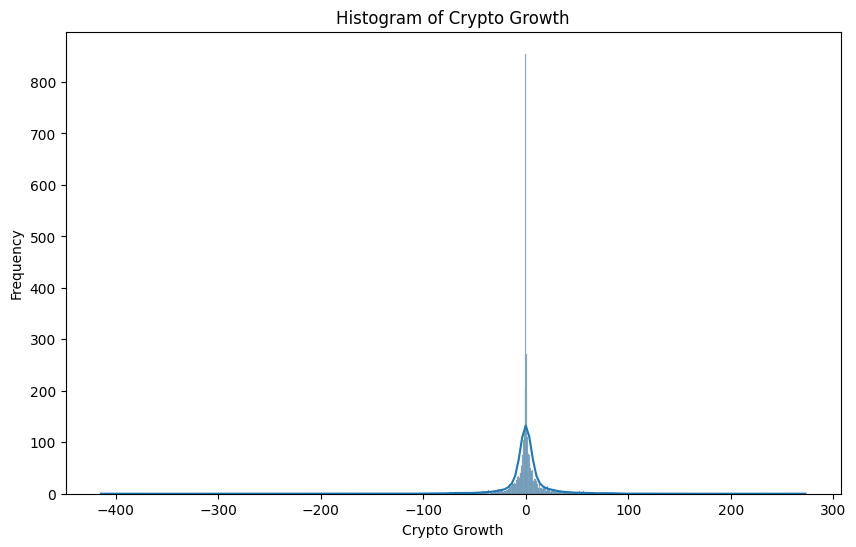

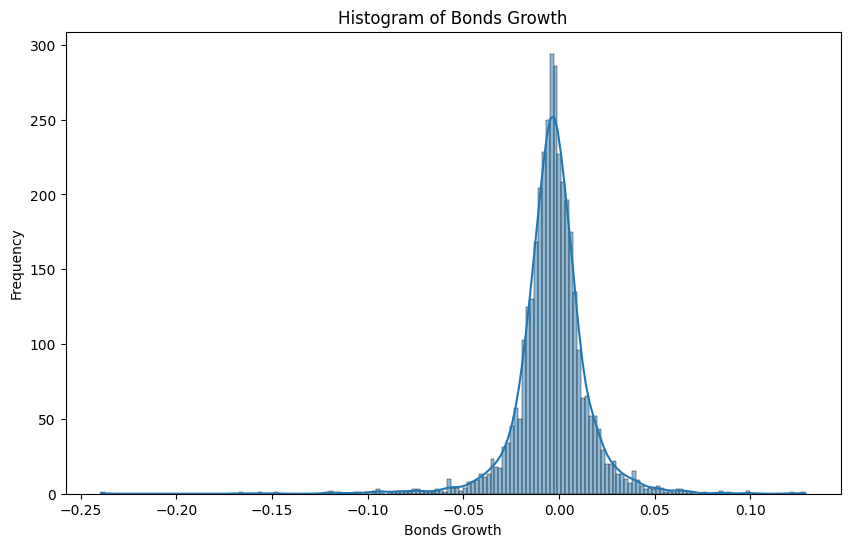

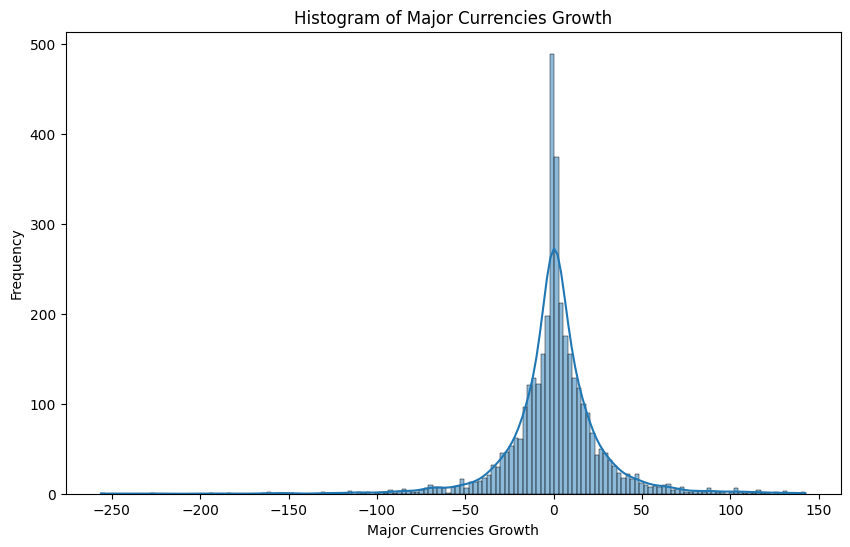

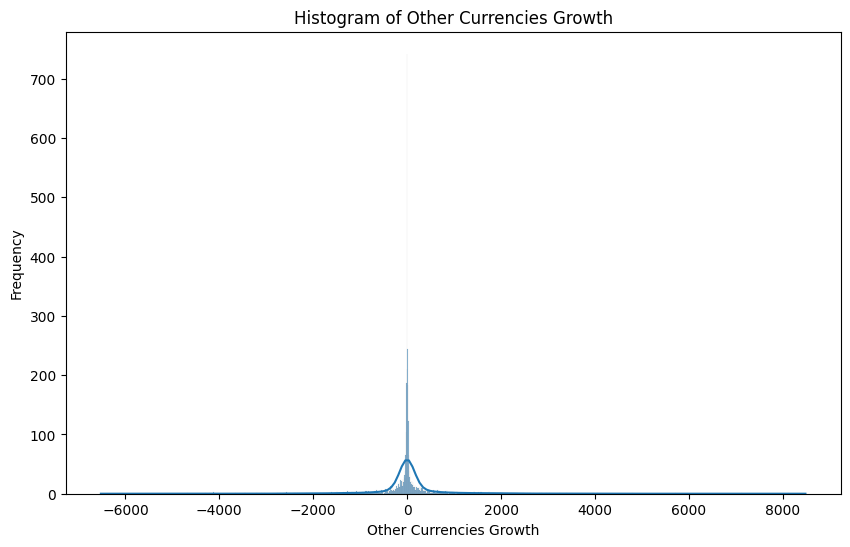

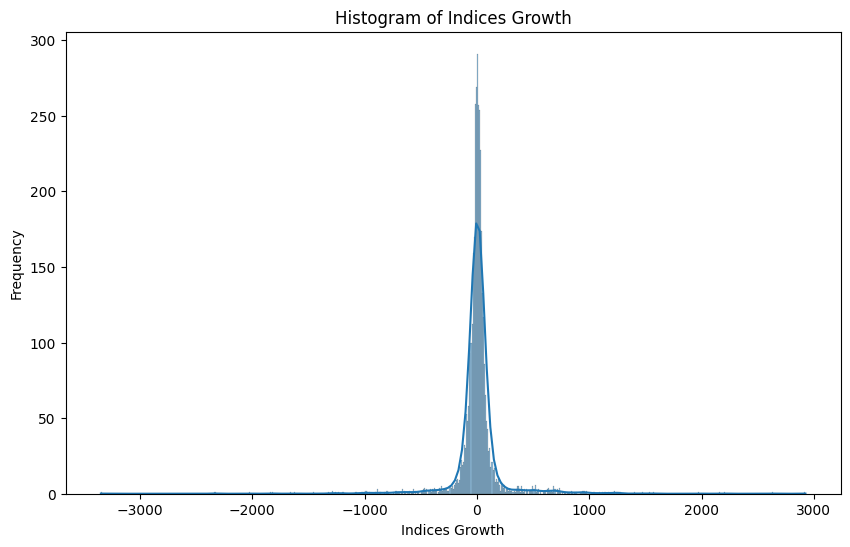

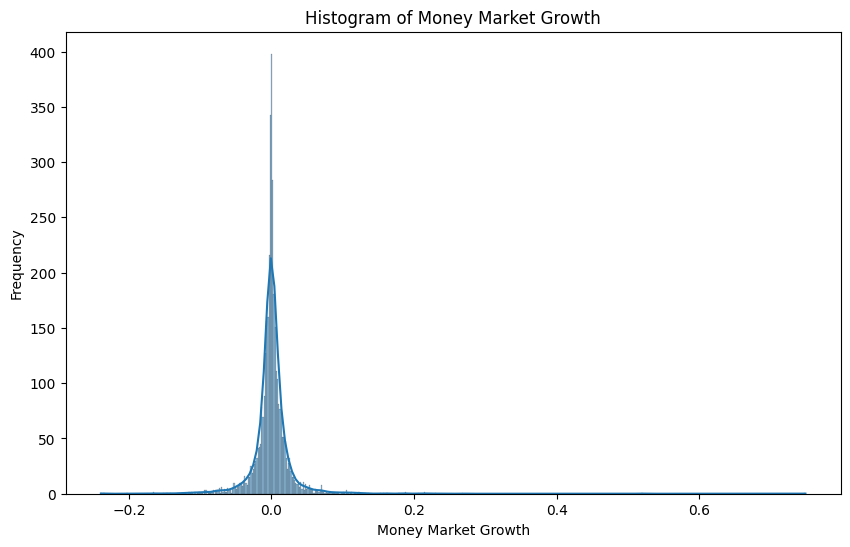

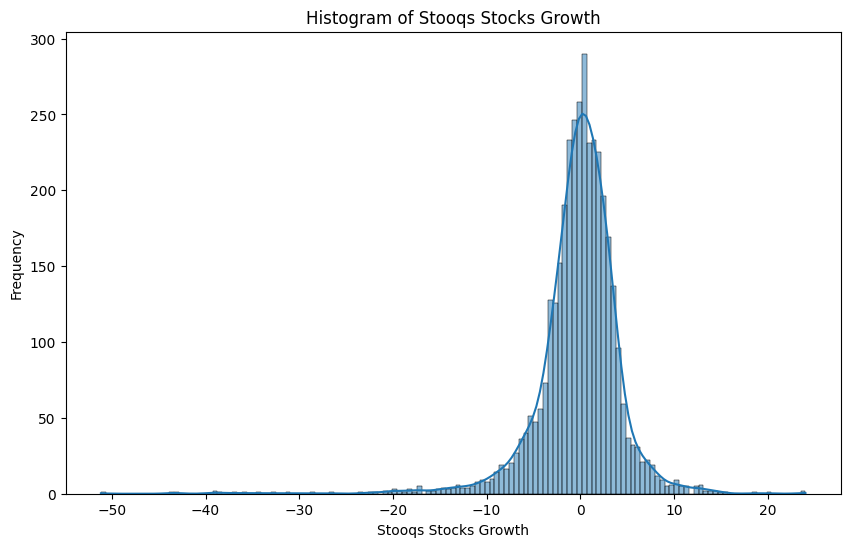

In [ ]:
# step two: for linear regression, must verify that the variables are normally distributed
# I don't think this will be a problem; volatility has a heavy right skew, but growth should have plenty of both positive and negative values

import seaborn as sns
import matplotlib.pyplot as plt

def column_histogram(df, col_name):
    """
    Plots a histogram of the volatility data.

    Args:
        df: Pandas DataFrame with volatility data.
        col_name: Name of the volatility column.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col_name], kde=True)  # kde adds a kernel density estimate
    plt.title(f'Histogram of {col_name}')
    plt.xlabel(f'{col_name}')
    plt.ylabel('Frequency')
    plt.show()

for column in growth_columns:
    column_histogram(growth_df, column)

In [ ]:
# looking at the results, nearly all of these columns do follow a normal distribution; the stocks growth has some negative skew, while the money market has some positive
# I think this should be good enough to at least attempt a linear regression model for predicting growth

# Since all of these are centered at zero, roughly, I can also attempt a model to simply predict whether each column had a positive or negative day based on the others,
# without taking into account magnitude

# I'll add boolean columns for this as well

growth_df_bool = growth_df.copy()

for column in growth_columns:
  growth_df_bool[f'{column} ?'] = growth_df[column] > 0

growth_df_bool.head()

,Crypto Growth,Bonds Growth,Major Currencies Growth,Other Currencies Growth,Indices Growth,Money Market Growth,Stooqs Stocks Growth,Crypto Growth ?,Bonds Growth ?,Major Currencies Growth ?,Other Currencies Growth ?,Indices Growth ?,Money Market Growth ?,Stooqs Stocks Growth ?
0,-0.00504,-0.001233,-1.335385,-0.043343,23.229492,-0.1648,1.04,False,False,False,False,True,False,True
1,-0.00606,-0.016573,1.139422,0.033777,20.939833,-0.0288,-1.92,False,False,True,True,True,False,False
2,0.00447,-0.025235,0.361047,0.063285,11.914667,-0.0200,8.19,True,False,True,True,True,False,True
3,-0.02871,-0.018359,0.054496,0.009895,97.244746,0.0408,7.23,False,False,True,True,True,True,True
4,0.01212,-0.013021,-0.325834,0.074019,24.910169,0.0508,6.32,True,False,False,True,True,True,True


In [ ]:
# just out of curiosity I want to see how many of each column were positive and negative

for column in growth_columns:
  print(growth_df_bool[f'{column} ?'].value_counts())
  print()

Crypto Growth ?
True     1947
False    1763
Name: count, dtype: int64

Bonds Growth ?
False    2284
True     1426
Name: count, dtype: int64

Major Currencies Growth ?
True     1957
False    1753
Name: count, dtype: int64

Other Currencies Growth ?
True     1895
False    1815
Name: count, dtype: int64

Indices Growth ?
True     1995
False    1715
Name: count, dtype: int64

Money Market Growth ?
False    1913
True     1797
Name: count, dtype: int64

Stooqs Stocks Growth ?
True     1960
False    1750
Name: count, dtype: int64



In [ ]:
# interesting: there are slightly more positive growth days for nearly every category save Money Market and Bonds
# again out of curiosity I'll find the ratios of each and the average
growth_ratios = {}

print('Ratios:')

for column in growth_columns:
  column_name = f'{column} ?'
  true_count = growth_df_bool[column_name].value_counts()[True]
  false_count = growth_df_bool[column_name].value_counts()[False]
  growth_ratios[column] = true_count / false_count
  print(f'{column}: {true_count / false_count}')



# find the average of these
print(f'\nAverage: {sum(growth_ratios.values()) / len(growth_ratios)}')

Ratios:
Crypto Growth: 1.10436755530346
Bonds Growth: 0.6243432574430823
Major Currencies Growth: 1.1163719338277238
Other Currencies Growth: 1.044077134986226
Indices Growth: 1.163265306122449
Money Market Growth: 0.9393622582331417
Stooqs Stocks Growth: 1.12

Average: 1.015969635130869


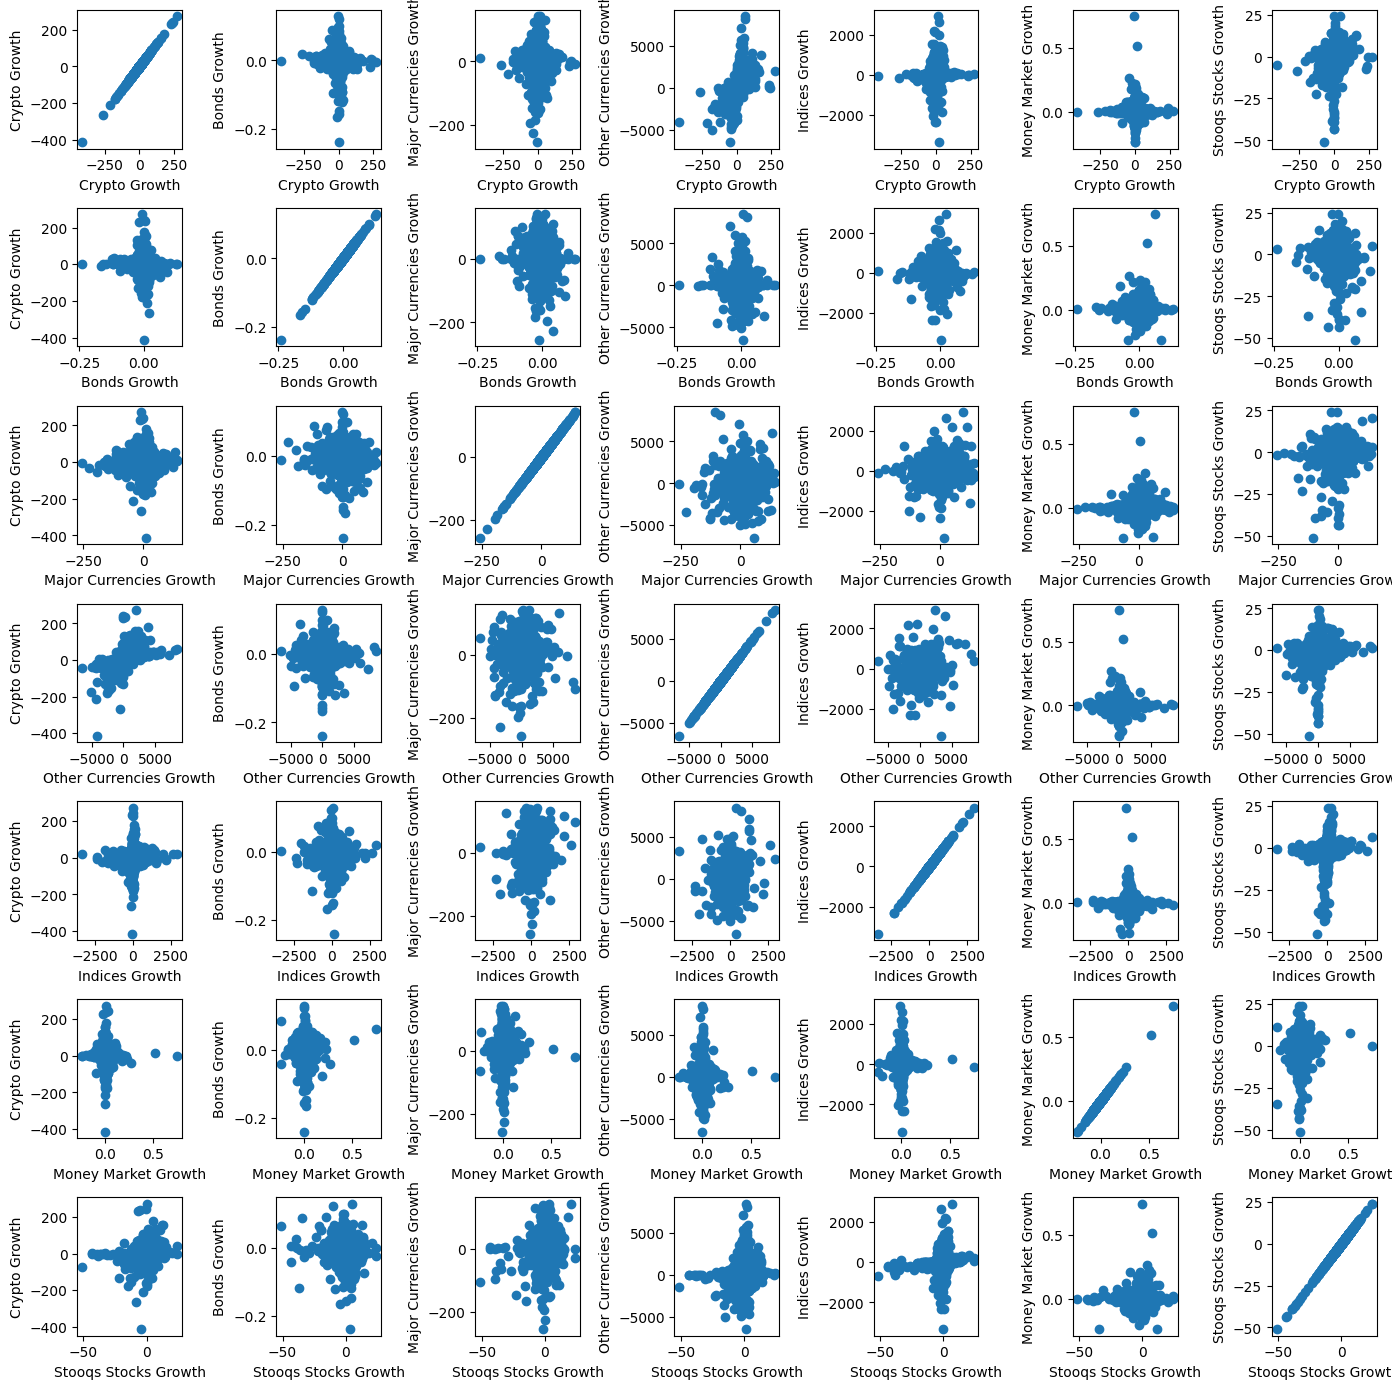

In [ ]:
# plot all the features against each other in a grid fashion

fig, axes = plt.subplots(nrows=len(growth_columns), ncols=len(growth_columns), figsize=(len(growth_columns) * 2, len(growth_columns) * 2))

for i in range(len(growth_columns)):
  for j in range(len(growth_columns)):
    column = growth_columns[i]
    column2 = growth_columns[j]

    axes[i, j].scatter(growth_df[column], growth_df[column2])
    axes[i, j].set_xlabel(column)
    axes[i, j].set_ylabel(column2)

plt.tight_layout()
plt.show()


In [ ]:
# well, it doesn't look there's any one value with strong predictors from another (the diagonals are to be ignored)
# I'm not entirely surprised but I was hoping there might be a few clear relations
# Since this is my query I will still train a model and at least find out just HOW inaccurate it is

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# some setup so we can easily reproduce model training for any of the attributes
def train_model(df, target_col):

  columns_to_keep = growth_df.columns.drop(target_col)
  X = growth_df[columns_to_keep]
  y = growth_df[target_col]

  # setup for cross validation
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  model = LinearRegression()
  model.fit(X_train, y_train)

  return model, X_test, y_test

# reports MSE and R-squared of the model as performance metrics
def report_accuracy(model, name, X_test, y_test):
  y_pred = model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  rsq = r2_score(y_test, y_pred)

  print(f'{name}: ')
  print(f'R-squared: {rsq}')
  print(f'Mean Squared Error: {mse}')


# let's try it for crypto
crypto_model, crypto_X_test, crypto_y_test = train_model(growth_df, "Crypto Growth")
report_accuracy(crypto_model, "Crypto", crypto_X_test, crypto_y_test)



Crypto: 
R-squared: 0.3338982155156879
Mean Squared Error: 356.3445942332862


In [ ]:
# that was pretty bad; lets try it for all of the columns
for column in growth_columns:
  col_model, X_test, Y_test = train_model(growth_df, column)
  report_accuracy(col_model, column, X_test, Y_test)
  print()

Crypto Growth: 
R-squared: 0.3338982155156879
Mean Squared Error: 356.3445942332862

Bonds Growth: 
R-squared: 0.01003933662263512
Mean Squared Error: 0.0003227198669040925

Major Currencies Growth: 
R-squared: 0.029991205527204023
Mean Squared Error: 727.9087363642519

Other Currencies Growth: 
R-squared: 0.3443622117620343
Mean Squared Error: 339282.27600451483

Indices Growth: 
R-squared: 0.0628977846836063
Mean Squared Error: 55131.659454214634

Money Market Growth: 
R-squared: -0.0017613558005165064
Mean Squared Error: 0.0010148559378363022

Stooqs Stocks Growth: 
R-squared: 0.06912413730639189
Mean Squared Error: 19.222790478929568



In [ ]:
# Still poor performance.
# As an alternative route, lets instead try to predict for a binary variable, the positive or negative growth of each category
# Since this is a binary response variable, we will instead use a logistic regression

from sklearn.linear_model import LogisticRegression

growth_columns_bool = [f'{col} ?' for col in growth_columns]

print(growth_columns_bool)

for column in growth_columns_bool:
  growth_df_bool[column] = growth_df_bool[column].astype(int)

growth_df_bool.head()



['Crypto Growth ?', 'Bonds Growth ?', 'Major Currencies Growth ?', 'Other Currencies Growth ?', 'Indices Growth ?', 'Money Market Growth ?', 'Stooqs Stocks Growth ?']


,Crypto Growth,Bonds Growth,Major Currencies Growth,Other Currencies Growth,Indices Growth,Money Market Growth,Stooqs Stocks Growth,Crypto Growth ?,Bonds Growth ?,Major Currencies Growth ?,Other Currencies Growth ?,Indices Growth ?,Money Market Growth ?,Stooqs Stocks Growth ?
0,-0.00504,-0.001233,-1.335385,-0.043343,23.229492,-0.1648,1.04,0,0,0,0,1,0,1
1,-0.00606,-0.016573,1.139422,0.033777,20.939833,-0.0288,-1.92,0,0,1,1,1,0,0
2,0.00447,-0.025235,0.361047,0.063285,11.914667,-0.0200,8.19,1,0,1,1,1,0,1
3,-0.02871,-0.018359,0.054496,0.009895,97.244746,0.0408,7.23,0,0,1,1,1,1,1
4,0.01212,-0.013021,-0.325834,0.074019,24.910169,0.0508,6.32,1,0,0,1,1,1,1


Crypto Growth
['Bonds Growth', 'Major Currencies Growth', 'Other Currencies Growth', 'Indices Growth', 'Money Market Growth', 'Stooqs Stocks Growth']
Crypto Growth Accuracy: 0.6792452830188679


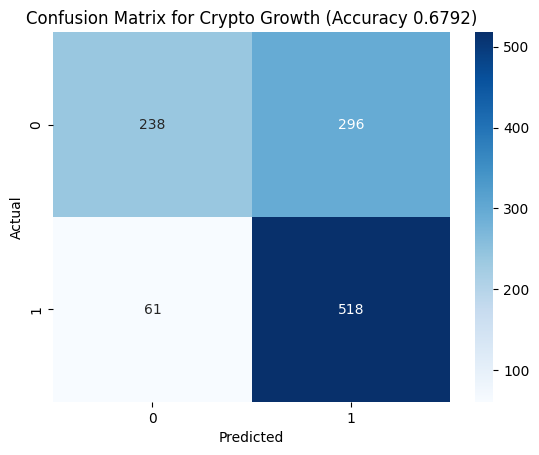


Bonds Growth
['Crypto Growth', 'Major Currencies Growth', 'Other Currencies Growth', 'Indices Growth', 'Money Market Growth', 'Stooqs Stocks Growth']
Bonds Growth Accuracy: 0.6316262353998203


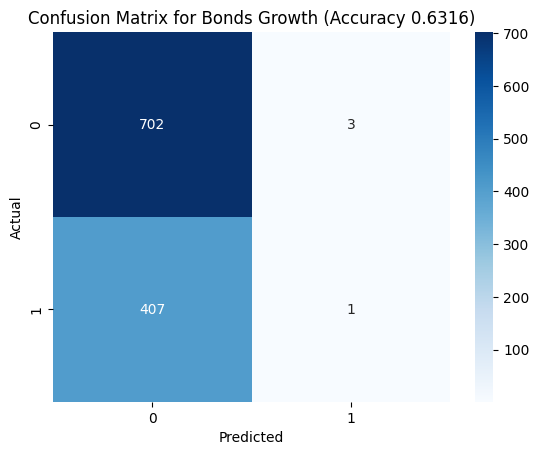


Major Currencies Growth
['Crypto Growth', 'Bonds Growth', 'Other Currencies Growth', 'Indices Growth', 'Money Market Growth', 'Stooqs Stocks Growth']
Major Currencies Growth Accuracy: 0.5327942497753818


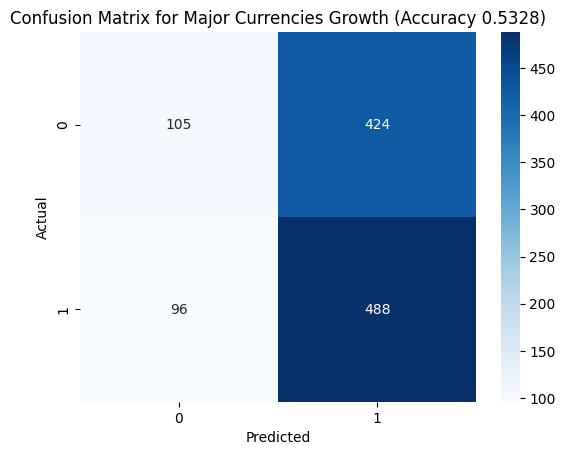


Other Currencies Growth
['Crypto Growth', 'Bonds Growth', 'Major Currencies Growth', 'Indices Growth', 'Money Market Growth', 'Stooqs Stocks Growth']
Other Currencies Growth Accuracy: 0.7169811320754716


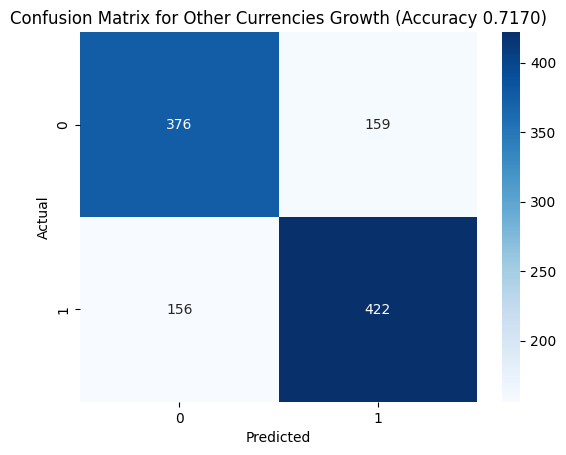


Indices Growth
['Crypto Growth', 'Bonds Growth', 'Major Currencies Growth', 'Other Currencies Growth', 'Money Market Growth', 'Stooqs Stocks Growth']
Indices Growth Accuracy: 0.6891284815813118


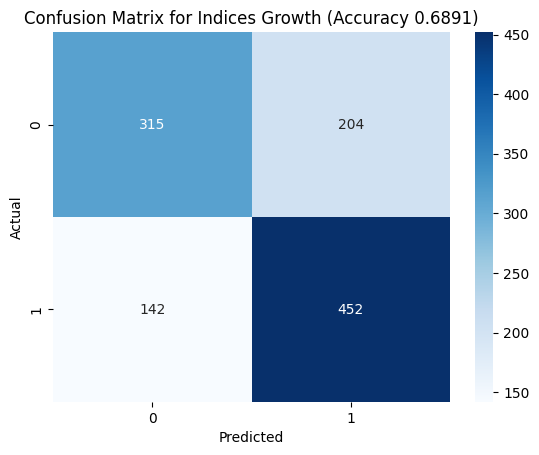


Money Market Growth
['Crypto Growth', 'Bonds Growth', 'Major Currencies Growth', 'Other Currencies Growth', 'Indices Growth', 'Stooqs Stocks Growth']
Money Market Growth Accuracy: 0.5327942497753818


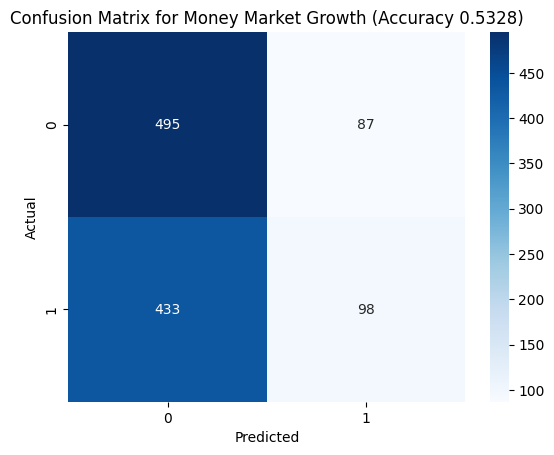


Stooqs Stocks Growth
['Crypto Growth', 'Bonds Growth', 'Major Currencies Growth', 'Other Currencies Growth', 'Indices Growth', 'Money Market Growth']
Stooqs Stocks Growth Accuracy: 0.6433063791554358


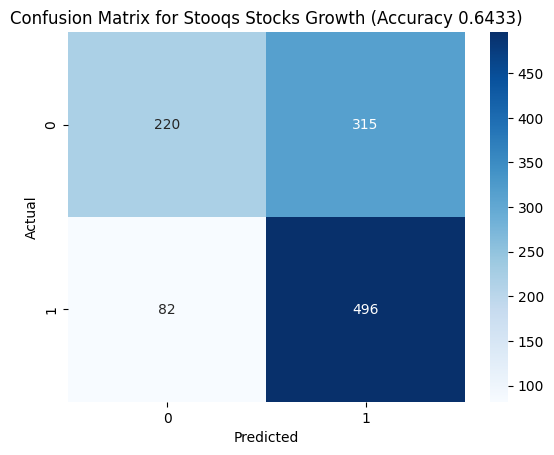

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# similar to before, but for training multiple logistic regression models
def train_logistic_model(df, target_col):
  # drop the other boolean columns, as well as this boolean and this numerical column
  columns_to_keep = []

  for column in df.columns:
    if not(column == target_col or '?' in column):
      columns_to_keep.append(column)

  X = df[columns_to_keep]
  y = df[f'{target_col} ?']

  print(target_col)
  print(columns_to_keep)

  # setup for cross validation
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
  model = LogisticRegression(max_iter=200)
  model.fit(X_train, y_train)

  return model, X_test, y_test

# now run for each column and see what comes of it
for column in growth_columns:
  col_model, X_test, y_test = train_logistic_model(growth_df_bool, column)

  y_pred = col_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)

  print(f'{column} Accuracy: {accuracy}')

  matrix = confusion_matrix(y_test, y_pred)

  # visually demonstrate the confusion matrix for each model
  sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
  plt.title(f'Confusion Matrix for {column} (Accuracy {accuracy:.4f})')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()
  print()